In [1]:
import os
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white', {'xtick.bottom': True, 'ytick.left': True})
sns.set_context('notebook', font_scale=2)

In [2]:
# color scheme for figures
import visual_behavior.ophys.response_analysis.utilities as ut
colors = ut.get_colors_for_image_sets()

In [3]:
experiment_dir = '/media/brian/Seagate Portable Drive/brianhhu/data/visual_behavior_pilot_manuscript_initial_submission/'
model_dir = '/home/brian/data/stsp_final/noise_std_0.5_pos_weight_5_l2_pen_0.001_patience_5/RESULT/'

In [4]:
manifest = pd.read_csv(os.path.join(experiment_dir,'visual_behavior_data_manifest.csv'))

In [5]:
selected_data = manifest[(manifest.cre_line=='Slc17a7-IRES2-Cre')&  # Vip-IRES-Cre
                         (manifest.session_type=='behavior_session_A')] #&  # behavior_session_B, C, D
#                          (manifest.targeted_structure=='VISp')]  # VISp
selected_data

,experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,specimen_id,experiment_date
8,639253368,639001089,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,334310,599659785,9/28/2017 14:14
12,661423848,661409179,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,355469,643316601,2/6/2018 15:03
16,670396087,670266085,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,355471,644831080,3/6/2018 13:37
28,692342909,692315205,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,369320,656813113,4/30/2018 16:09
40,729951441,729705760,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,382897,679238912,8/3/2018 10:11
44,715228642,715094648,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,384942,687987489,6/27/2018 13:08
48,720001924,719860866,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,384942,687987489,7/13/2018 14:33
52,719321260,719538773,VISal,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,385255,685152008,7/12/2018 10:27
64,754566180,754511300,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,401625,717693518,9/17/2018 15:13
84,768224465,768053094,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,407486,739783701,10/24/2018 14:21


In [6]:
experiment_id = selected_data.experiment_id.values
experiment_id

array([639253368, 661423848, 670396087, 692342909, 729951441, 715228642,
       720001924, 719321260, 754566180, 768224465, 760696146, 774379465,
       673139359])

In [7]:
from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis 

In [8]:
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.svm import LinearSVC, SVC

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Linear SVM vs non-linear RBF SVC
model = LinearSVC(C=1.0,max_iter=1e4)
model_nl = SVC(C=1.0,max_iter=1e4,gamma='scale')

nCrossVal = 3

In [9]:
# feature pre-processing included here
clf = make_pipeline(StandardScaler(), model)

# Decoding analysis

In [10]:
# Loop over all experiments
results = {}

adaptation_index_all = []
image_coef_all = []
change_coef_all = []

# for determining catch trial predictions
cv = StratifiedKFold(n_splits=3)

# # choose random image order
# idx = np.random.permutation(['im085', 'im066', 'im061', 'im065', 'im077', 'im069', 'im063', 'im062'])

for e in experiment_id:
    dataset= VisualBehaviorOphysDataset(e, cache_dir=experiment_dir)
    analysis = ResponseAnalysis(dataset, use_events=False)  # dff or events?
    
    # Organize results dict by experiment id
    results[str(e)] = {}
    
    # get trials and flash dataframe
    tdf = analysis.trial_response_df
    fdf = analysis.flash_response_df
    
    # merge on change time
    fdf['change_time'] = fdf.start_time.values
#     fdf = pd.merge(fdf, dataset.all_trials[['change_time', 'initial_image_name', 'change_image_name', 'trial_type']],
#                                  on='change_time', how='left')
    fdf = pd.merge(fdf, dataset.all_trials[['change_time', 'initial_image_name', 'change_image_name', 'trial_type', 'response', 'response_type']],
                                 on='change_time', how='left')
    
    ### ADDED: to compute adaptation index ###
    # use pre-change image vs. change image response
    go_df = fdf[(fdf.engaged==True)&(fdf.trial_type=='go')]
    go_response = go_df.groupby('cell')['mean_response'].mean()
    catch_response = fdf[fdf.flash_number.isin(go_df.flash_number.unique()-1)].groupby('cell')['mean_response'].mean()
    
    # don't use cells with negative mean dF/F in either go or catch
    go_response = go_response[(go_response>0)&(catch_response>0)]
    catch_response = catch_response[(go_response>0)&(catch_response>0)]
        
#     # try rectification (bounds the index and is more similar to the models)
#     go_response[go_response<0] = 0
#     catch_response[catch_response<0] = 0
    
    adaptation_index = (go_response - catch_response) / (go_response + catch_response)
    adaptation_index_all.append(adaptation_index.values)
    
    # change modulation
    results[str(e)]['change_modulation'] = adaptation_index.values
    
    # get the cell ids
    cell_ids = adaptation_index.index
    
    # map image name to categorical variable
    fdf['image_index'] = fdf['image_name'].astype('category').cat.codes
    
    # find number of cells and number of flashes
    num_cells = len(cell_ids)  # fdf.cell_specimen_id.unique())
    num_flashes = len(fdf.flash_number.unique())
    
    # extract image change times
    change_times = fdf[fdf.cell_specimen_id==fdf.cell_specimen_id.unique()[0]].change_time.values
    
    # extract responses (cells x num flashes)
#     traces = fdf.mean_response.values.reshape(-1, num_cells)
    traces = fdf[fdf.cell.isin(cell_ids)].mean_response.values.reshape(-1, num_cells)
    print(traces.shape)
        
#     # decode image identity
#     img_idx = fdf[(fdf.engaged==True)&(fdf.image_name!='omitted')&(fdf.image_name.isin(idx[:4]))].flash_number.unique()
#     X = traces[img_idx, :]
#     y = fdf.loc[(fdf.flash_number.isin(img_idx))&(fdf.cell_specimen_id==fdf.cell_specimen_id.unique()[0]), 'image_index']
#     for i, val in enumerate(np.unique(y)):
#         y[y==val] = i
#     cv_image = model.fit(X,y)
#     results[str(e)]['image'] = cv_image.score(X,y)

#     img_idx = fdf[(fdf.engaged==True)&(fdf.image_name!='omitted')&(fdf.image_name.isin(idx[4:]))].flash_number.unique()
#     X = traces[img_idx, :]
#     y = fdf.loc[(fdf.flash_number.isin(img_idx))&(fdf.cell_specimen_id==fdf.cell_specimen_id.unique()[0]), 'image_index']
#     for i, val in enumerate(np.unique(y)):
#         y[y==val] = i
#     results[str(e)]['image_gen'] = cv_image.score(X,y)
    
#     # decode image change
#     change_idx = fdf[(fdf.engaged==True)&(fdf.trial_type=='go')&(fdf.initial_image_name.isin(idx[:4]))&(fdf.change_image_name.isin(idx[:4]))].flash_number.unique()
#     X_change = traces[change_idx, :]
#     y_change = np.ones(len(change_idx))
#      # use the pre-change stimulus here
#     X_prechange = traces[change_idx-1, :]
#     y_prechange = np.zeros(len(change_idx))
#     X = np.concatenate((X_change, X_prechange))
#     y = np.concatenate((y_change, y_prechange))
#     cv_change = model.fit(X,y)
#     results[str(e)]['change'] = cv_change.score(X,y)

#     change_idx = fdf[(fdf.engaged==True)&(fdf.trial_type=='go')&(fdf.initial_image_name.isin(idx[4:]))&(fdf.change_image_name.isin(idx[4:]))].flash_number.unique()
#     X_change = traces[change_idx, :]
#     y_change = np.ones(len(change_idx))
#      # use the pre-change stimulus here
#     X_prechange = traces[change_idx-1, :]
#     y_prechange = np.zeros(len(change_idx))
#     X = np.concatenate((X_change, X_prechange))
#     y = np.concatenate((y_change, y_prechange))
#     results[str(e)]['change_gen'] = cv_change.score(X,y)
    
    # decode image identity
    img_idx = fdf[(fdf.engaged==True)&(fdf.image_name!='omitted')].flash_number.unique()
    X = traces[img_idx, :]
    y = fdf.loc[(fdf.flash_number.isin(img_idx))&(fdf.cell_specimen_id==fdf.cell_specimen_id.unique()[0]), 'image_index']
    cv_image = cross_validate(model,X,y,cv=nCrossVal,return_estimator=True)  # can also pass pipeline here
    results[str(e)]['image'] = cv_image['test_score'].mean()
    image_coef_all.append(np.concatenate([c.coef_ for c in cv_image['estimator']]).mean(axis=0))
    
    # decode image change
    change_idx = fdf[(fdf.engaged==True)&(fdf.trial_type=='go')].flash_number.unique()
    X_change = traces[change_idx, :]
    y_change = np.ones(len(change_idx))
     # use the pre-change stimulus here
    X_prechange = traces[change_idx-1, :]
    y_prechange = np.zeros(len(change_idx))
    X = np.concatenate((X_change, X_prechange))
    y = np.concatenate((y_change, y_prechange))
    cv_change = cross_validate(model,X,y,cv=nCrossVal,return_estimator=True)  # can also pass pipeline here
    results[str(e)]['change'] = cv_change['test_score'].mean()
    change_coef_all.append(np.concatenate([c.coef_ for c in cv_change['estimator']]).mean(axis=0))

    # correlate behavior and decoder
    # find catch trials
    catch_idx = fdf[(fdf.engaged==True)&(fdf.trial_type=='catch')].flash_number.unique()    
    X_catch = traces[catch_idx, :]
    y_catch = np.zeros(len(catch_idx))

    # actual behavior
    go_true = fdf.loc[(fdf.flash_number.isin(change_idx))&(fdf.cell_specimen_id==fdf.cell_specimen_id.unique()[0]), 'response'].values
    catch_true = fdf.loc[(fdf.flash_number.isin(catch_idx))&(fdf.cell_specimen_id==fdf.cell_specimen_id.unique()[0]), 'response'].values

    # model go trial predictions
    go_preds = cross_val_predict(model, X, y, cv=nCrossVal)[y==1]
    catch_preds = []
    for i, (_, test_index) in enumerate(cv.split(X_catch, y_catch), 1):
        catch_preds.append(cv_change['estimator'][-i].predict(X_catch[test_index]))
    catch_preds = np.concatenate(catch_preds)
    
    # store behavior and predictions for correlation analysis
    results[str(e)]['y_true'] = np.concatenate((go_true, catch_true))
    results[str(e)]['y_pred'] = np.concatenate((go_preds, catch_preds))
    
#     go_confusion_mat = np.zeros((2,2))
#     catch_confusion_mat = np.zeros((2,2))
#     # behavior values
#     for i in range(2):
#         # decoder values
#         for j in range(2):
#             go_confusion_mat[i,j] = (go_preds[go_true==i]==j).sum()
#             catch_confusion_mat[i,j] = (catch_preds[catch_true==i]==j).sum()

#     plt.figure()
# #     plt.subplot(1,2,1)
# #     # normalize confusion matrices
# #     plt.imshow(go_confusion_mat/go_confusion_mat.sum())
# #     plt.subplot(1,2,2)
# #     plt.imshow(catch_confusion_mat/catch_confusion_mat.sum())

#     plt.subplot(1,2,1)
#     # normalize confusion matrices (by column)
#     plt.imshow(go_confusion_mat/go_confusion_mat.sum(axis=0))
#     plt.subplot(1,2,2)
#     plt.imshow(catch_confusion_mat/catch_confusion_mat.sum(axis=0))

loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4786, 62)
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4786, 125)
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4787, 160)
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4786, 100)
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4786, 284)
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4786, 175)
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4786, 153)
loading trial response dataframe
loading flash response dataframe
loading omitted flash response dataframe
(4786, 57)
loading trial response dataframe
loading flash res

In [11]:
from sklearn.metrics import jaccard_similarity_score

In [12]:
# do this for every session, do a shuffle control
jaccard_similarity_score(np.concatenate((go_true, catch_true)), np.concatenate((go_preds, catch_preds)))

0.700507614213198

In [13]:
from scipy.stats import pearsonr

In [14]:
adaptation_index_all = np.concatenate(adaptation_index_all)
image_coef_all = np.concatenate(image_coef_all)
change_coef_all = np.concatenate(change_coef_all)

In [15]:
pearsonr(adaptation_index_all, change_coef_all)

(0.6527407790990124, 4.358650976909294e-239)

In [16]:
pearsonr(adaptation_index_all, image_coef_all)

(0.06844347035594622, 0.0023943189344019554)

In [18]:
from matplotlib.ticker import FormatStrFormatter

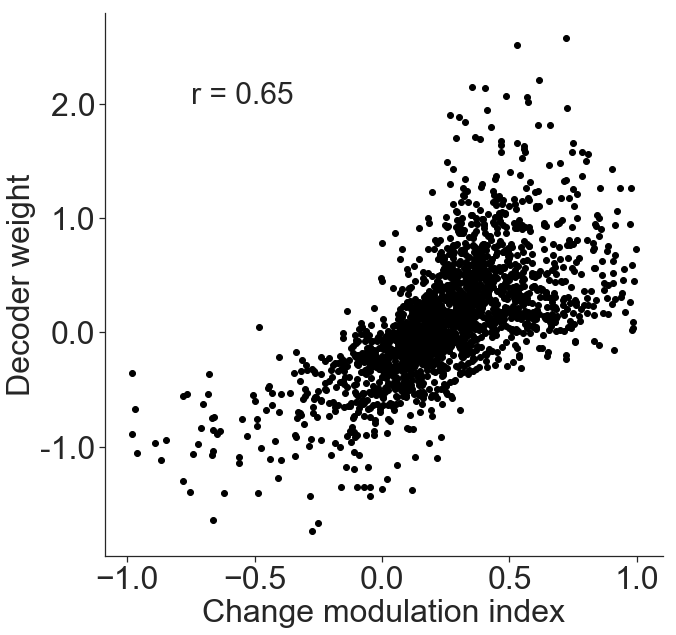

In [32]:
sns.set_style({'axes.spines.right': False, 'axes.spines.top': False})

plt.figure(figsize=(10,10))  # originally (10,6)

plt.scatter(adaptation_index_all, change_coef_all, color='black')
pearsonr(adaptation_index_all, change_coef_all)  # correlation between adaptation index and change decoder coefficients
# plt.legend(['r={:.2f}'.format(pearsonr(adaptation_index_all, change_coef_all)[0])], frameon=False)

# plt.text(-0.75, 2, 'r = {:.2f}; p = {:.2f}'.format(*pearsonr(adaptation_index_all, change_coef_all)), fontsize=24)
plt.text(-0.75, 2, 'r = {:.2f}'.format(pearsonr(adaptation_index_all, change_coef_all)[0]), fontsize=30)

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().tick_params(axis='both', which='major', labelsize=32)
plt.xlabel('Change modulation index', fontsize=32)
plt.ylabel('Decoder weight', fontsize=32)

plt.savefig('figures/cm_decoder_weight_new.png', dpi=300, bbox_inches='tight')

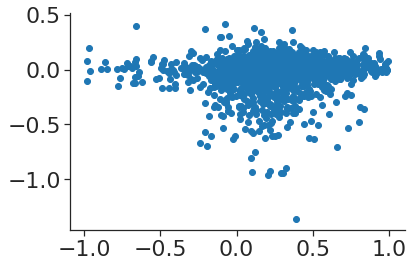

In [776]:
plt.scatter(adaptation_index_all, image_coef_all)

---

In [295]:
# Save generalization results
pickle.dump(results, open('generalization_results.pkl', 'wb'))

In [24]:
results_df = pd.DataFrame(columns=['ophys_experiment_id', 'session_id', 'decoding_type', 'mean_accuracy'])

In [25]:
# loop through nested dict
cnt = 0
for i, (k2, v2) in enumerate(results.items()):
    ophys_experiment_id = k2
    session_id='A'
    results_df.loc[cnt] = pd.Series({'ophys_experiment_id': ophys_experiment_id, 'session_id': session_id, 'decoding_type': 'image', 'mean_accuracy': v2['image']})
    results_df.loc[cnt+1] = pd.Series({'ophys_experiment_id': ophys_experiment_id, 'session_id': session_id, 'decoding_type': 'change', 'mean_accuracy': v2['change']})
    cnt += 2

In [26]:
results_df  # this shows generalization results

,ophys_experiment_id,session_id,decoding_type,mean_accuracy
0,715228642,A,image,0.953553
1,715228642,A,change,0.869565
2,670396087,A,image,0.845924
3,670396087,A,change,0.724400
4,720001924,A,image,0.842368
5,720001924,A,change,0.789683
6,774379465,A,image,0.789730
7,774379465,A,change,0.843333
8,661423848,A,image,0.992593
9,661423848,A,change,0.899503


In [27]:
results_df.groupby(['decoding_type']).mean_accuracy.mean()

decoding_type
change    0.793806
image     0.867385
Name: mean_accuracy, dtype: float64

# Visualize results

### Trained image transitions

Text(0,0.5,'Decoder accuracy')

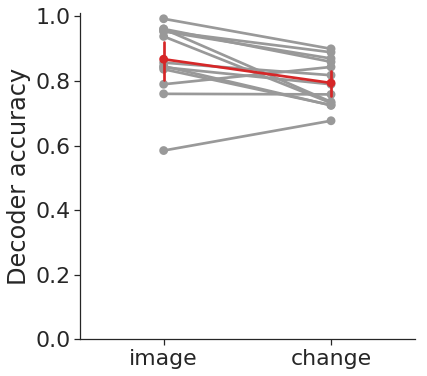

In [818]:
plt.figure(figsize=(6,6))

ax = sns.pointplot(x="decoding_type", y="mean_accuracy", kind="point", color=colors[0], data=results_df)

# move to background
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

g = sns.pointplot(x="decoding_type", y="mean_accuracy", hue='ophys_experiment_id', kind="point", palette=[[0.6, 0.6, 0.6]], data=results_df, ax=ax)
g.legend_.remove()

ax.set(ylim=(0, 1.01))
ax.set_xlabel('')
ax.set_ylabel('Decoder accuracy')

# plt.savefig('figures/decoding.png', dpi=300, bbox_inches='tight')

# Look at correlation with behavior

In [34]:
# save true jaccard and shuffled jaccard
# jaccard_true = []
# jaccard_shuffle = []
N_shuffles = 1000
behavior_df = pd.DataFrame(columns=['ophys_experiment_id', 'session_id', 'decoding_type', 'mean_accuracy'])

cnt = 0
for i, (k2, v2) in enumerate(results.items()):
    y_true = results[k2]['y_true']
    y_pred = results[k2]['y_pred']
    
    # true values
#     jaccard_true.append(jaccard_similarity_score(y_true, y_pred))
    behavior_df.loc[cnt] = pd.Series({'ophys_experiment_id': k2, 'session_id': 'A', 'decoding_type': 'behavior', 'mean_accuracy': jaccard_similarity_score(y_true, y_pred)})
    
    # shuffle
    temp = []
    for i in range(N_shuffles):
        temp.append(jaccard_similarity_score(y_true, np.random.permutation(y_pred)))
                    
#     jaccard_shuffle.append(np.array(temp).mean())
    behavior_df.loc[cnt+1] = pd.Series({'ophys_experiment_id': k2, 'session_id': 'A', 'decoding_type': 'shuffled', 'mean_accuracy': np.array(temp).mean()})
    cnt += 2

In [29]:
behavior_df

,ophys_experiment_id,session_id,decoding_type,mean_accuracy
0,715228642,A,behavior,0.632911
1,715228642,A,shuffled,0.555519
2,670396087,A,behavior,0.684211
3,670396087,A,shuffled,0.580125
4,720001924,A,behavior,0.834483
5,720001924,A,shuffled,0.583269
6,774379465,A,behavior,0.800000
7,774379465,A,shuffled,0.591094
8,661423848,A,behavior,0.835714
9,661423848,A,shuffled,0.646893


Text(0,0.5,'Jaccard similarity')

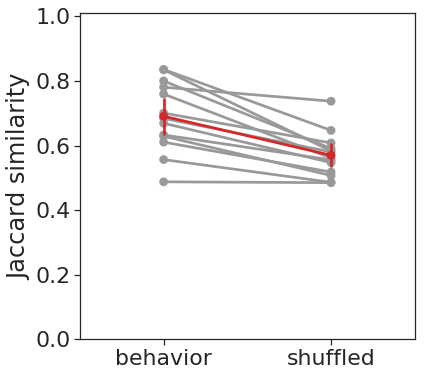

In [31]:
plt.figure(figsize=(6,6))

ax = sns.pointplot(x="decoding_type", y="mean_accuracy", kind="point", color=colors[0], data=behavior_df)

# move to background
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

g = sns.pointplot(x="decoding_type", y="mean_accuracy", hue='ophys_experiment_id', kind="point", palette=[[0.6, 0.6, 0.6]], data=behavior_df, ax=ax)
g.legend_.remove()

ax.set(ylim=(0, 1.01))
ax.set_xlabel('')
ax.set_ylabel('Jaccard similarity')

# plt.savefig('figures/behavior_similarity.png', dpi=300, bbox_inches='tight')

In [33]:
behavior_df.groupby('decoding_type')['mean_accuracy'].apply(np.mean)

decoding_type
behavior    0.690820
shuffled    0.569769
Name: mean_accuracy, dtype: float64

---

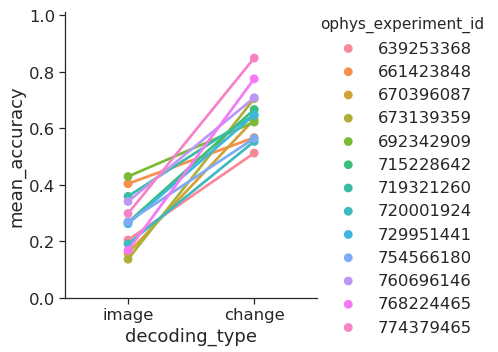

In [664]:
ax = sns.catplot(x="decoding_type", y="mean_accuracy", hue="ophys_experiment_id", kind="point", data=results_df)
ax.set(ylim=(0, 1.01))
# plt.savefig('decoding_a1_a3.png', dpi=200, bbox_inches='tight')

### Generalization on unseen image transitions

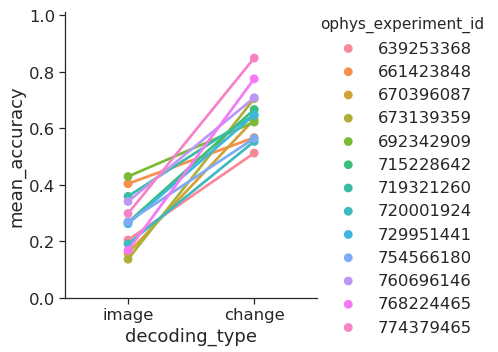

In [287]:
ax = sns.catplot(x="decoding_type", y="mean_accuracy", hue="ophys_experiment_id", kind="point", data=results_df)
ax.set(ylim=(0, 1.01))
# plt.savefig('decoding_a1_a3.png', dpi=200, bbox_inches='tight')

---

# Model decoding

In [56]:
rnn_weights = np.load('rnn_output_weights.npy')
stsp_weights = np.load('stpnet_output_weights.npy')

In [57]:
stsp_inp_array = []
rnn_inp_array = []
for model in ['STSPNet', 'RNN']:
    for seed in range(1,11):
        directory = model_dir+model+'/'+model+'_A_'+str(seed)+'.pkl'

        model_data = pickle.load(open(directory, 'rb'))
        
        # get necessary items
        image = model_data['image']
        label = model_data['labels'].squeeze()
        input_act = model_data['hidden']  # NOTE: using hidden instead of input
        
#         # use go and catch images
#         mean_inp_act_go = input_act[(label==1)].mean(axis=0)
#         mean_inp_act_catch = input_act[(label==-1)].mean(axis=0)
        
        # use change and pre-change images
        idx = np.argwhere(label==1)
        mean_inp_act_go = input_act[idx[:,0], idx[:,1]].mean(axis=0)
        mean_inp_act_catch = input_act[idx[:,0], idx[:,1]-3].mean(axis=0)
        
        if model == 'STSPNet':
            stsp_inp_array.append((mean_inp_act_go, mean_inp_act_catch))
        else:
            rnn_inp_array.append((mean_inp_act_go, mean_inp_act_catch))

In [58]:
stsp_input_go = np.stack([m[0] for m in stsp_inp_array]).flatten()
stsp_input_catch = np.stack([m[1] for m in stsp_inp_array]).flatten()

rnn_input_go = np.stack([m[0] for m in rnn_inp_array]).flatten()
rnn_input_catch = np.stack([m[1] for m in rnn_inp_array]).flatten()

In [59]:
adaptation_index_stsp = (stsp_input_go - stsp_input_catch) / (stsp_input_go + stsp_input_catch)
adaptation_index_rnn = (rnn_input_go - rnn_input_catch) / (rnn_input_go + rnn_input_catch)

/home/brianh/miniconda3/envs/vis-behav/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.


In [60]:
from scipy.stats import pearsonr

# RNN

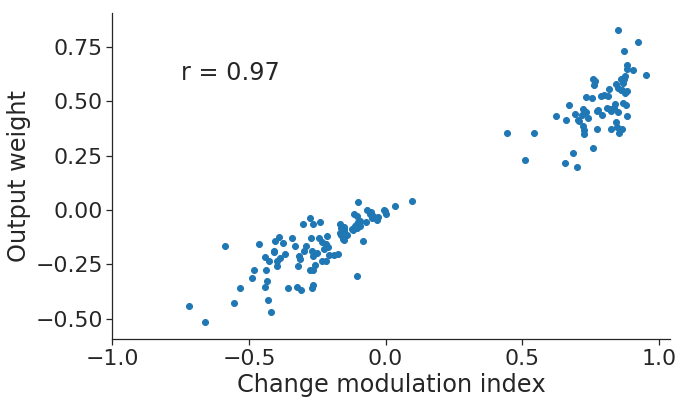

In [62]:
sns.set_style({'axes.spines.right': False, 'axes.spines.top': False})
plt.figure(figsize=(10,6))

# filter by nans
rnn_weights = rnn_weights[~np.isnan(adaptation_index_rnn)]
adaptation_index_rnn = adaptation_index_rnn[~np.isnan(adaptation_index_rnn)]

plt.scatter(adaptation_index_rnn, rnn_weights)
plt.text(-0.75, 0.6, 'r = {:.2f}'.format(pearsonr(adaptation_index_rnn, rnn_weights)[0]), fontsize=24)

plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.xlabel('Change modulation index')
plt.ylabel('Output weight')
# plt.title('RNN', fontsize=20)

plt.savefig('RNN_weight_adaptation', dpi=300, bbox_inches='tight')

# STPNet

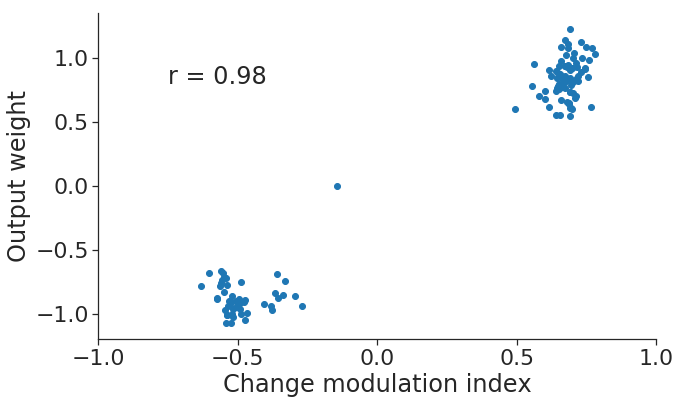

In [61]:
plt.figure(figsize=(10,6))

# Note some hidden units in STPNet never respond (i.e. they are always silent!)
# stsp_weights = stsp_weights[~np.isnan(adaptation_index_stsp)]
# adaptation_index_stsp = adaptation_index_stsp[~np.isnan(adaptation_index_stsp)]

# filter instead by positive responses
stsp_weights = stsp_weights[(stsp_input_go>0)&(stsp_input_catch>0)]
adaptation_index_stsp = adaptation_index_stsp[(stsp_input_go>0)&(stsp_input_catch>0)]

plt.scatter(adaptation_index_stsp, stsp_weights)
plt.text(-0.75, 0.8, 'r = {:.2f}'.format(pearsonr(adaptation_index_stsp, stsp_weights)[0]), fontsize=24)

plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.xlabel('Change modulation index')
plt.ylabel('Output weight')
# plt.title('STPNet', fontsize=20)

plt.savefig('STPNet_weight_adaptation', dpi=300, bbox_inches='tight')